<a href="https://colab.research.google.com/github/adityakangune/MLOps_Image_Pipeline/blob/main/Persistent_AB_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A/B testing: A step-by-step guide in Python

We will do the process of analysing an A/B test, from formulating a hypothesis, testing it, and finally interpreting results. 

Dataset used: https://www.kaggle.com/datasets/zhangluyuan/ab-testing?select=ab_data.csv

It contains the results of an A/B test on what seems to be 2 different designs of a website page (old_page vs. new_page).

1. [Designing our experiment](#1.-Designing-our-experiment)
2. [Collecting and preparing the data](#2.-Collecting-and-preparing-the-data)
3. [Visualising the results](#3.-Visualising-the-results)
4. [Testing the hypothesis](#4.-Testing-the-hypothesis)
5. [Drawing conclusions](#5.-Drawing-conclusions)

To make it a bit more realistic, here's a potential **scenario** for our study:

> Let's imagine you work on the product team at a medium-sized **online e-commerce business**. The UX designer worked really hard on a new version of the product page, with the hope that it will lead to a higher conversion rate. The product manager (PM) told you that the **current conversion rate** is about **13%** on average throughout the year, and that the team would be happy with an **increase of 2%**, meaning that the new design will be considered a success if it raises the conversion rate to 15%.

Before rolling out the change, the team would be more comfortable testing it on a small number of users to see how it performs, so you suggest running an **A/B test** on a subset of your user base users.

***
## 1. Designing our experiment

### Formulating a hypothesis

First things first, we want to make sure we formulate a hypothesis at the start of our project. This will make sure our interpretation of the results is correct as well as rigorous.

Given we don't know if the new design will perform better or worse (or the same?) as our current design, we'll choose a <a href="https://en.wikipedia.org/wiki/One-_and_two-tailed_tests">**two-tailed test**</a>:

$$H_0: p = p_0$$
$$H_a: p \ne p_0$$

where $p$ and $p_0$ stand for the conversion rate of the new and old design, respectively. We'll also set a **confidence level of 95%**:

$$\alpha = 0.05$$

The $\alpha$ value is a threshold we set, by which we say "if the probability of observing a result as extreme or more ($p$-value) is lower than $\alpha$, then we reject the null hypothesis". Since our $\alpha=0.05$ (indicating 5% probability), our confidence (1 - $\alpha$) is 95%.

Don't worry if you are not familiar with the above, all this really means is that whatever conversion rate we observe for our new design in our test, we want to be 95% confident it is statistically different from the conversion rate of our old design, before we decide to reject the Null hypothesis $H_0$. 

### Choosing the variables

For our test we'll need **two groups**:
* A `control` group - They'll be shown the old design
* A `treatment` (or experimental) group - They'll be shown the new design

This will be our *Independent Variable*. The reason we have two groups even though we know the baseline conversion rate is that we want to control for other variables that could have an effect on our results, such as seasonality: by having a `control` group we can directly compare their results to the `treatment` group, because the only systematic difference between the groups is the design of the product page, and we can therefore attribute any differences in results to the designs.

For our *Dependent Variable* (i.e. what we are trying to measure), we are interested in capturing the `conversion rate`. A way we can code this is by  each user session with a binary variable:
* `0` - The user did not buy the product during this user session
* `1` - The user bought the product during this user session

This way, we can easily calculate the mean for each group to get the conversion rate of each design.

### Choosing a sample size

It is important to note that since we won't test the whole user base (our <a href="https://www.bmj.com/about-bmj/resources-readers/publications/statistics-square-one/3-populations-and-samples">population</a>), the conversion rates that we'll get will inevitably be only *estimates* of the true rates.

The number of people (or user sessions) we decide to capture in each group will have an effect on the precision of our estimated conversion rates: **the larger the sample size**, the more precise our estimates (i.e. the smaller our confidence intervals), **the higher the chance to detect a difference** in the two groups, if present.

On the other hand, the larger our sample gets, the more expensive (and impractical) our study becomes.

*So how many people should we have in each group?*

The sample size we need is estimated through something called <a href="https://research.usu.edu//irb/wp-content/uploads/sites/12/2015/08/A_Researchers_Guide_to_Power_Analysis_USU.pdf">*Power analysis*</a>, and it depends on a few factors:
* **Power of the test** ($1 - \beta$) - This represents the probability of finding a statistical difference between the groups in our test when a difference is actually present. This is usually set at 0.8 as a convention (here's more info on <a href="https://en.wikipedia.org/wiki/Power_of_a_test">statistical power</a>, if you are curious)
* **Alpha value** ($\alpha$) - The critical value we set earlier to 0.05
* **Effect size** - How big of a difference we expect there to be between the conversion rates

Since our team would be happy with a difference of 2%, we can use 13% and 15% to calculate the effect size we expect. 

Luckily, **Python takes care of all these calculations for us**:

In [1]:
# Packages imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

# Some plot styling preferences
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
effect_size = sms.proportion_effectsize(0.13, 0.15)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

4720


We'd need **at least 4720 observations for each group**. 

Having set the `power` parameter to 0.8 in practice means that if there exists an actual difference in conversion rate between our designs, assuming the difference is the one we estimated (13% vs. 15%), we have about 80% chance to detect it as statistically significant in our test with the sample size we calculated.

***
## 2. Collecting and preparing the data

Great stuff! So now that we have our required sample size, we need to collect the data. Usually at this point you would work with your team to set up the experiment, likely with the help of the Engineering team, and make sure that you collect enough data based on the sample size needed.

However, since we'll use a dataset that we found online, in order to simulate this situation we'll:
1. Download the <a href='https://www.kaggle.com/zhangluyuan/ab-testing?select=ab_data.csv'>dataset from Kaggle</a>
2. Read the data into a pandas DataFrame
3. Check and clean the data as needed
4. Randomly sample `n=4720` rows from the DataFrame for each group *****

***Note**: Normally, we would not need to perform step 4, this is just for the sake of the exercise

Since I already downloaded the dataset, I'll go straight to number 2.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
! unzip /content/drive/MyDrive/Datasets/ab_testing_data.zip

Archive:  /content/drive/MyDrive/Datasets/ab_testing_data.zip
  inflating: ab_data.csv             


In [8]:
df = pd.read_csv("/content/ab_data.csv")

df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [10]:
# To make sure all the control group are seeing the old page and viceversa

pd.crosstab(df['group'], df['landing_page'])

# Compute a simple cross tabulation of two (or more) factors.
# By default computes a frequency table of the factors unless an array of values and an aggregation function are passed.

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


There are **294478 rows** in the DataFrame, each representing a user session, as well as **5 columns** :
* `user_id` - The user ID of each session
* `timestamp` - Timestamp for the session
* `group` - Which group the user was assigned to for that session {`control`, `treatment`}
* `landing_page` - Which design each user saw on that session {`old_page`, `new_page`}
* `converted` - Whether the session ended in a conversion or not (binary, `0`=not converted, `1`=converted)

We'll actually only use the `group` and `converted` columns for the analysis.

Before we go ahead and sample the data to get our subset, let's make sure there are no users that have been sampled multiple times.

In [11]:
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 3894 users that appear multiple times in the dataset


There are, in fact, users that appear more than once. Since the number is pretty low, we'll go ahead and remove them from the DataFrame to avoid sampling the same users twice.

In [12]:
users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {df.shape[0]} entries')

The updated dataset now has 286690 entries


### Sampling

Now that our DataFrame is nice and clean, we can proceed and sample `n=4720` entries for each of the groups. We can use pandas' `DataFrame.sample()` method to do this, which will perform Simple Random Sampling for us. 

**Note**: I've set `random_state=22` so that the results are reproducible if you feel like following on your own Notebook: just use `random_state=22` in your function and you should get the same sample as I did.

In [13]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

In [14]:
ab_test

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
9435,908512,2017-01-14 22:02:29.922674,treatment,new_page,0
9436,873211,2017-01-05 00:57:16.167151,treatment,new_page,0
9437,631276,2017-01-20 18:56:58.167809,treatment,new_page,0
9438,662301,2017-01-03 08:10:57.768806,treatment,new_page,0


In [15]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9440 non-null   int64 
 1   timestamp     9440 non-null   object
 2   group         9440 non-null   object
 3   landing_page  9440 non-null   object
 4   converted     9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In [16]:
ab_test['group'].value_counts()

control      4720
treatment    4720
Name: group, dtype: int64

Great, looks like everything went as planned, and we are now ready to analyse our results.

***
## 3. Visualising the results

The first thing we can do is to calculate some **basic statistics** to get an idea of what our samples look like.

In [17]:
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.123,0.329,0.005
treatment,0.126,0.331,0.005


Judging by the stats above, it does look like **our two designs performed very similarly**, with our new design performing slightly better, approx. **12.3% vs. 12.6% conversion rate**.

Plotting the data will make these results easier to grasp:

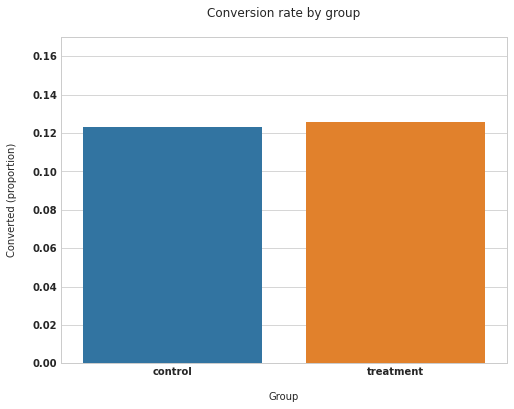

In [18]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

The conversion rates for our groups are indeed very close. Also note that the conversion rate of the `control` group is lower than what we would have expected given what we knew about our avg. conversion rate (12.3% vs. 13%). This goes to show that there is some variation in results when sampling from a population.

So... the `treatment` group's value is higher. **Is this difference *statistically significant***?

***
## 4. Testing the hypothesis

The last step of our analysis is testing our hypothesis. Since we have a very large sample, we can use the <a href="https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Normal_approximation_interval">normal approximation</a> for calculating our $p$-value (i.e. z-test). 

Again, Python makes all the calculations very easy. We can use the `statsmodels.stats.proportion` module to get the $p$-value and confidence intervals:

In [19]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [20]:
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

In [21]:
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.34
p-value: 0.732
ci 95% for control group: [0.114, 0.133]
ci 95% for treatment group: [0.116, 0.135]


***
## 5. Drawing conclusions

Since our $p$-value=0.732 is way above our $\alpha$=0.05, we cannot reject the null hypothesis $H_0$, which means that our new design did not perform significantly different (let alone better) than our old one :(

Additionally, if we look at the confidence interval for the `treatment` group ([0.116, 0.135], i.e. 11.6-13.5%) we notice that:
1. It includes our baseline value of 13% conversion rate
2. It does not include our target value of 15% (the 2% uplift we were aiming for)

What this means is that it is more likely that the true conversion rate of the new design is similar to our baseline, rather than the 15% target we had hoped for. This is further proof that our new design is not likely to be an improvement on our old design, and that unfortunately we are back to the drawing board! 